# Recommend three strains based on strain, effects, and flavors proposed by app user.

'Documents' are constructed by string representations of **Strain**, **Effects**, and **Flavors**. 
- A SpaCy instance is used to create a search space by vectorizing the docs.
- The docs are vectorized.
- A function is defined to take a text, searches the space, and returns three closest matches.

## Import code needed.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('./data/cannabis.csv')

## Exploratory Data Analysis

In [18]:
df.shape
# df.head()
# df.groupby('Rating').count()

(2162, 6)

## Limit search and results to quality straains.

In [ ]:
good_stuff = df[df['Rating'] >= 4.0]
good_stuff.shape

## Replace Not a Number values to avoid errors.

In [20]:
# replace blank flavor with ""
good_stuff = df.replace(np.nan, '', regex=True)

## A function to standardize string input:

In [19]:
def clean_string(strng):
    s = strng.replace(","," ") # comma-> space
    s = s.replace("("," ") # (-> space
    s = s.replace(")"," ") # (-> space
    s = s.lower()
    return s

## Combine labels into one string, for vectorization.

In [21]:
# cols = good_stuff.columns
cols = ['Type', 'Effects', 'Flavor', 'Description']

for col in cols:
    good_stuff[col] = good_stuff[col].apply(clean_string)

good_stuff['text'] = good_stuff['Type'] + " " + good_stuff['Effects'] + " " + good_stuff['Flavor']

In [22]:
# good_stuff.iloc[0]['text']
# good_stuff.shape

(2351, 7)

In [13]:
# !pip install spacy
!pip install spacy download en_core_web_lg
import spacy
spacy.load("en_core_web_lg")

## Load Spacy to use embedding strings in a space to be used to find similar results.

In [10]:
!python -m spacy link en_core_web_lg en

✔ Linking successful
/home/gt/anaconda3/lib/python3.7/site-packages/en_core_web_lg -->
/home/gt/anaconda3/lib/python3.7/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [11]:
nlp = spacy.load('en')

In [74]:
# nlp

# Build a list of docs to use fitting model.

In [25]:
def gather_docs(df):
    """ Produces List of Documents from a dataframe.
    
    df: a Pandas dataframe that has the column 'text'.
    
    Returns a list of strings. 
    """
    
    docs = list(df['text'])
    
    return docs

In [28]:
# docs = gather_docs(good_stuff)
# docs[:5]

['hybrid creative energetic tingly euphoric relaxed earthy sweet citrus',
 'hybrid relaxed aroused creative happy energetic flowery violet diesel',
 'sativa uplifted happy relaxed energetic creative spicy/herbal sage woody',
 'hybrid tingly creative hungry relaxed uplifted apricot citrus grapefruit',
 'hybrid happy relaxed euphoric uplifted talkative citrus earthy orange']

# Instantiate Vectorizer.

In [33]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(stop_words='english', max_features=1000)

## Fit vectorizer to docs.

In [ ]:
# Fit our documents
vect.fit(docs)

## Make a Document-Term Matrix, and Densify.

In [ ]:
#Create a sparse document-term matrix
dtm = vect.transform(docs)

# Make a dataframe of a condensed version of the DTM, using feature names
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())

In [77]:
# dtm.head()

In [35]:
doc_len = [len(doc) for doc in docs]

## Make histogram of occurrence of words in 'docs'.

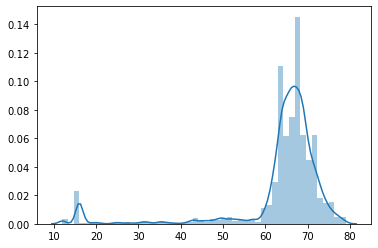

In [36]:
import seaborn as sns
sns.distplot(doc_len);

## Instandiate and fit a nearest neighbors learner.

In [37]:
from sklearn.neighbors import NearestNeighbors
# Fit on DTM
n = NearestNeighbors(n_neighborsn=3, algorithm='kd_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                 radius=1.0)

In [38]:
# inspect
nn.kneighbors([dtm.iloc[0].values])

(array([[0., 2., 2.]]), array([[ 0, 91, 81]]))

In [65]:
test_text = [ """hybrid creative energetic tesla euphoric monster earthy sweet citrus"""]

In [43]:
# input_dtm = vect.transform(test_text)
# input_dtm
# input_dtm = pd.DataFrame(input_dtm.todense(), columns=vect.get_feature_names())

In [67]:
new = vect.transform(test_text)

In [61]:
new

<1x68 sparse matrix of type '<class 'numpy.int64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [68]:
nn.kneighbors(new.todense())

(array([[1.41421356, 1.41421356, 1.41421356]]), array([[429,   0,  91]]))

In [73]:
# Inspect Most relevant result
docs[429]

'hybrid creative euphoric focused happy energetic citrus earthy sweet'

## Define function to use in retrieving three nearest.

In [71]:
# def clean_string(strng):
#     s = strng.replace(","," ") # comma-> space
#     s = s.replace("("," ") # (-> space
#     s = s.replace(")"," ") # (-> space
#     s = s.lower()
#     return s

def text_to_top_three(txt):
    """ Receives a string containing strain, effects, and flavors, and 
    
    returns a 2-tuple of (array of scores, array of indexes) describing
    
    the best matches among strains modeled."""
    
    clean_text = clean_string(txt)
    transformed_text = vect.transform(clean_text)
    return nn.kneighbors(transformed_text.todense())